In [106]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import pandas as pd
import numpy as np
from collections import defaultdict

# Some useful utilities

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon, size=len(v))

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

def z_clip(xs, b):
    return [min(x, b) for x in xs]

def g_clip(v):
    n = np.linalg.norm(v, ord=2)
    if n > 1:
        return v / n
    else:
        return v

# Logistic Regression with Scikit-Learn

The dataset files you'll need are available here:

- [`adult_processed_x`](https://github.com/jnear/cs295-data-privacy/blob/master/slides/adult_processed_x.npy)
- [`adult_processed_y`](https://github.com/jnear/cs295-data-privacy/blob/master/slides/adult_processed_y.npy)

In [2]:
X = np.load('adult_processed_x.npy')
y = np.load('adult_processed_y.npy')

We generally split our data into a "training set" and a "test set." We train the model on the training set, and test its accuracy on the test set. The goal is to avoid "overfitting" - a model that simply memorizes the training data, and can't generalize to new data.

In [3]:
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

y_test.shape

(9044,)

We'll mainly use logistic regression, but the techniques we'll see apply to a number of different machine learning tasks. Scikit-learn has logistic regression built in.

In [4]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(X_train,y_train)
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [5]:
model.predict(X_test)

array([-1., -1., -1., ..., -1., -1., -1.])

In [6]:
# We can use the test set to test our new model
model.predict(X_test) == y_test

array([ True, False,  True, ...,  True,  True,  True], dtype=bool)

In [7]:
# Ratio of correct answers to total
np.sum(model.predict(X_test) == y_test)/X_test.shape[0]

0.84464838567005751

# Our own Gradient Descent

What does Scikit-learn actually do? We'll look at a simple but effective algorithm for training - gradient descent.

In [11]:
# Prediction: take a model (theta) and a single example (xi) and return its predicted label
def predict(theta, xi):
    label = np.sign(xi @ theta)
    return label

In [26]:
# We can take an initial guess at theta - a vector of all zeros.
# It won't be very accurate.
theta = np.zeros(X_train.shape[1])
predict(theta, X_test[0])

0.0

In [13]:
# The loss function measures how good our model is. The training goal is to minimize the loss.
# This is the logistic loss function.
def loss(theta, xi, yi):
    exponent = - yi * (xi.dot(theta))
    return np.log(1 + np.exp(exponent))

In [14]:
# We can use the loss function to measure the effectiveness of our current theta
loss(np.reshape(model.coef_, (104, 1)), X_train[0], y_train[0])
loss(theta, X_train[0], y_train[0])

0.69314718055994529

In [15]:
np.mean([loss(theta, X_train[i], y_train[i]) for i in range(10000)])

0.69314718055994529

In [17]:
# This is the gradient of the logistic loss
# The gradient is a vector that indicates in which direction the loss function is increasing fastest
def gradient(theta, xi, yi):
    exponent = yi * (xi.dot(theta))
    return - (yi*xi) / (1+np.exp(exponent))

In [23]:
# If we take a step in the *opposite* direction from the gradient (by negating it), we should 
# move theta in a direction that makes the loss *lower*
# This is one step of gradient descent - in each step, we're trying to "descend" the gradient
# In this example, we're taking the gradient on just a single training example (the first one)
theta = theta - gradient(theta, X_train[0], y_train[0])
theta

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.51351237,
        0.        ,  0.        ,  0.        , -0.51351237,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.51351237,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.51351237,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.51351237,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.51351237,
        0.        , -0.51351237,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [25]:
# Now our model is better!
predict(theta, X_test[0]) == y_test[0]

True

In [31]:
# Let's measure the accuracy of our "zeros theta" - it's not good
theta = np.zeros(X_train.shape[1])
[predict(theta, xi) for xi in X_test] == y_test
np.sum([predict(theta, xi) for xi in X_test] == y_test)

0

In [46]:
# Now take one step of gradient descent and try again
theta = theta - gradient(theta, X_train[0], y_train[0])
[predict(theta, xi) for xi in X_test] == y_test

array([ True, False,  True, ...,  True,  True,  True], dtype=bool)

In [35]:
# The new model labels 75% of the test set correctly!
display(y_test.shape)
np.sum([predict(theta, xi) for xi in X_test] == y_test) / y_test.shape[0]

(9044,)

0.75851393188854488

In [47]:
# our measure of accuracy is just % correct of the test set
def accuracy(theta, X, y):
    return np.sum([predict(theta, xi) for xi in X] == y) / y.shape[0]

accuracy(theta, X_test, y_test)

0.75851393188854488

## A step of gradient descent

The basic gradient descent algorithm takes the *average* gradient over all of the examples in the training set, and steps in the opposite direction.

In [49]:
theta = np.zeros(X_train.shape[1])
theta1 = theta - np.mean([gradient(theta, xi, yi) for xi, yi in zip(X_train, y_train)], axis=0)
accuracy(theta1, X_test, y_test)

0.75851393188854488

In [50]:
# We'll use the average gradient a lot, so we define a function for it
def avg_grad(theta, X, y):
    return np.mean([gradient(theta, xi, yi) for xi, yi in zip(X, y)], axis=0)

In [54]:
# This is the basic gradient descent algorithm, run for 10 steps (10 iterations)
# At each step, we print out the loss. Notice that it decreases with each step.
theta = np.zeros(X_train.shape[1])

for i in range(10):
    theta = theta - avg_grad(theta, X_train, y_train)
    display(np.mean([loss(theta, X_train[i], y_train[i]) for i in range(10000)]))

accuracy(theta, X_test, y_test)

0.55507606543433174

0.52743894635227084

0.50711714383727191

0.4916876964348964

0.47967792569340956

0.47011075871430719

0.46232417347066274

0.45586210682683342

0.45040486337426139

0.44572431306271937

0.77874834144183991

In [55]:
theta

array([  1.63933476e-02,  -2.62737908e-02,  -3.76703876e-01,
         5.75414219e-02,  -6.45755008e-02,  -2.73486282e-02,
        -1.30672661e-03,  -5.91543132e-02,  -7.64880798e-02,
        -2.62061378e-02,  -1.57561761e-02,  -2.86662073e-02,
        -4.72301785e-02,  -3.76260473e-02,  -9.90166218e-03,
        -1.97245917e-02,   1.55177596e-01,   4.49929106e-02,
        -3.29796604e-01,   1.19518106e-01,  -4.89454322e-03,
         6.88790663e-02,  -1.55396891e-01,  -1.80599005e-01,
         1.54260151e-03,   3.89119966e-01,  -1.97894731e-02,
        -5.15748994e-01,  -5.58626968e-02,  -4.09361505e-02,
        -1.28065226e-01,  -1.62203385e-04,  -1.08119029e-01,
         1.88498244e-01,  -6.47481586e-02,  -8.66006277e-02,
        -9.99400278e-02,  -2.05565204e-01,  -1.11388992e-02,
         1.61706332e-01,  -3.59862313e-03,  -1.50012146e-02,
         1.68869178e-03,  -5.12278071e-02,   3.20211424e-01,
        -2.99730645e-01,  -6.21807885e-02,  -2.79987375e-01,
        -1.81265739e-01,

# Gradient descent with privacy

In [67]:
# This is gradient descent with a *learning rate* "eta"
def gradient_descent():
    theta = np.zeros(X_train.shape[1])
    eta = 1.0

    for i in range(10):
        theta = theta - eta * avg_grad(theta, X_train, y_train)

    display(accuracy(theta, X_test, y_test))
    return theta

In [68]:
gradient_descent()

0.77874834144183991

array([  1.63933476e-02,  -2.62737908e-02,  -3.76703876e-01,
         5.75414219e-02,  -6.45755008e-02,  -2.73486282e-02,
        -1.30672661e-03,  -5.91543132e-02,  -7.64880798e-02,
        -2.62061378e-02,  -1.57561761e-02,  -2.86662073e-02,
        -4.72301785e-02,  -3.76260473e-02,  -9.90166218e-03,
        -1.97245917e-02,   1.55177596e-01,   4.49929106e-02,
        -3.29796604e-01,   1.19518106e-01,  -4.89454322e-03,
         6.88790663e-02,  -1.55396891e-01,  -1.80599005e-01,
         1.54260151e-03,   3.89119966e-01,  -1.97894731e-02,
        -5.15748994e-01,  -5.58626968e-02,  -4.09361505e-02,
        -1.28065226e-01,  -1.62203385e-04,  -1.08119029e-01,
         1.88498244e-01,  -6.47481586e-02,  -8.66006277e-02,
        -9.99400278e-02,  -2.05565204e-01,  -1.11388992e-02,
         1.61706332e-01,  -3.59862313e-03,  -1.50012146e-02,
         1.68869178e-03,  -5.12278071e-02,   3.20211424e-01,
        -2.99730645e-01,  -6.21807885e-02,  -2.79987375e-01,
        -1.81265739e-01,

In [77]:
# This is a differentially private version of gradient descent:
# At each iteration, we use the Gaussian mechanism to add enough noise to the gradient to
# make it differentially private. By post-processing, the update we perform afterwards satisfies
# differential privacy.
# We're assuming the sensitivity is 1 - but it's not. We'll fix that later.
def dp_gradient_descent(epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    eta = 1.0

    for i in range(10):
        theta = theta - eta * gaussian_mech_vec(avg_grad(theta, X_train, y_train), 1, epsilon, delta)

    return accuracy(theta, X_test, y_test)
    #return theta

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[(0.10000000000000001, 0.37394957983193278),
 (11.200000000000001, 0.67138434321096863),
 (22.300000000000004, 0.75077399380804954),
 (33.400000000000006, 0.74104378593542686),
 (44.500000000000007, 0.73452012383900933),
 (55.600000000000009, 0.7568553737284387),
 (66.700000000000003, 0.76448474126492705),
 (77.800000000000011, 0.77841662980981863),
 (88.900000000000006, 0.78814683768244143),
 (100.0, 0.7816231755860239)]

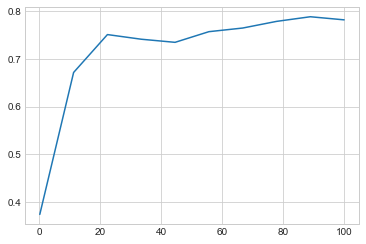

In [80]:
# The accuracy of the model degrades as we add more noise
# This is because the training algorithm can go the wrong direction because of the noise.
xs = np.linspace(0.1, 100.0, 10)
ys = [dp_gradient_descent(x, 1e-5) for x in xs]
plt.plot(xs,ys)
display(list(zip(xs,ys)))

In [85]:
# We can bound the sensitivity of the gradient by clipping
# A common strategy is to clip the gradient for *each example* so that it has L2 norm of 1
# Then the sensitivity of a single-example gradient is 1

# L2 sensitivity: 1 by clipping
def clip_gradient(theta, xi, yi):
    exponent = yi * (xi.dot(theta))
    return g_clip(- (yi*xi) / (1+np.exp(exponent)))

# When we take the average over all examples, the sensitivity is 1/n, where n is the size of the training set.
# This is just like the averages we've seen in database-style examples: only one example will change
# between neighboring datasets, so the sensitivity of the sum of examples is just 1.

# L2 sensitivity: 1/X.shape[0] by averaging
def avg_clip_grad(theta, X, y):
    return np.mean([clip_gradient(theta, xi, yi) for xi, yi in zip(X, y)], axis=0)

In [100]:
# Now we can use a sensitivity of 1/X_train.shape[0] to get differential privacy for each iteration
# This is a huge win - sensitivity is very small when you have a large dataset
# As you increase the amount of data you're training on, the sensitivity gets better
def dp_gradient_descent(epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    eta = 1.0

    for i in range(10):
        theta = theta - eta * gaussian_mech_vec(avg_clip_grad(theta, X_train, y_train), 1/X_train.shape[0], epsilon, delta)

    return accuracy(theta, X_test, y_test)
    #return theta

In [105]:
[dp_gradient_descent(0.001, 1e-5) for x in range(5)]

[0.65413533834586468,
 0.51658558160106149,
 0.47202565236620964,
 0.37914639540026535,
 0.66298098186643073]

In [ ]:
# What's missing? Composition! Each step of our algorithm above is differentially private, but we haven't
# bounded the *total* privacy cost of the algorithm. There are lots of ways to do this: advanced composition,
# Renyi differential privacy, zCDP, etc.